# Generalisierung funktionaler Zusammenhänge

In den letzten Kapiteln haben wir Modelle kennen gelernt, die für quantitative und kategoriale Prognoseprobleme verwendet werden können. Ziel der Modellierung ist immer den tatsächlichen Zusammenhang zwischen den unabhängigen Variablen $x_1, ..., x_p$ und einer abhängigen Variablen $y$ möglichst gut abzubilden. Bisher haben wir immer den gesamten Datensatz verwendet, um die Modelle zu trainieren und haben verschiedene Kennzahlen kennen gelernt, die verwendet werden können, die Güte der Modelle für die Trainingsdaten zu bestimmen. Leider ist es jedoch so, dass eine hohe Modellgüte für die Trainingsdaten nicht unbedingt auch eine hohe Modellgüte für neue Testdaten zur Folge haben muss. Gelingt dies jedoch nicht, kann nicht davon ausgegangen werden, dass ein Modell den allgemein bestehenden Zusammenhang zwischen unabhängigen und abhängigen Variablen abbildet. Entsprechend ist es wichtig ein Modell immer für neue, nicht beim Trainieren des Modells verwendete, Daten zu evaluieren. Daten sind jedoch nicht in beliebiger Menge verfügbar, weshalb normalerweise ein Teil der Trainingsdaten nicht für die Schätzung der Modellparameter, sondern zur Evaluation der out-of-sample Performance verwendet wird. Im Folgenden verwenden wir die Termini Trainings- und Testfehler um die Güte eines Modells für Trainings- und Testdaten zu bezeichnen. 

## Einfacher Split der Daten

Die einfachste Möglichkeit den Testfehler zu schätzen, besteht darin den gesamten Datensatz zufällig aufzuteilen und einen Teil zum Trainieren des Modells und zur Ermittlung des Trainingsfehlers zu bestimmen, während der Testfehler mit dem geschätzten Modell für die Testdaten ermittelt wird. In der nächsten Zelle kehren wir zum Advertising Datensatz aus dem Kapitel der linearen Regression zurück und teilen die Daten zufällig in Trainings- und Testdaten auf. Zunächst machen wir dies in gleichen Anteilen. Der Trainingsdatensatz wird zur Schätung der Parameter des linearen Regressionsmodells verwendet, im Anschluss berechnen wir den mittleren quadratischen Fehler (MSE) der Trainings- und Testdaten. Um ein Gefühl für die Schwankung bei der Schätzung des Testfehlers zu bekommen, führen wir diesen Vorgang $100$ Mal durch. Die untere Grafik zeigt die Histogramme der MSE des Trainings- und des Testdatensatzes. Zum einen fällt auf, dass es im Testdatensatz im Mittelwert zu einem etwas höheren MSE kommt als im Trainingsdatensatz (vertikale Linie). Zudem erkennen wir auch, dass die Variation des MSE im Testdatensatz relativ hoch ist. Dies ist dann problematisch, wenn wir uns vorstellen, dass wir unsere Beurteilung des Models nur auf eine zufällige Aufteilung der Daten stützen würden. Mit dem unten vorgestellten Vorgehen des mehrfachen Aufteilens haben wir dieses Problem nicht, jedoch ist das gezeigt Vorgehen aus einem anderen Grund kritisch zu sehen. In unserem Beispiel teilen wir die Daten gleichmäßig auf, was dazu führt, dass nur die Hälfte der Daten zum Trainieren des Modells verwendet werden kann. Dies erhöht die Varianz der Prognosen aus dem Modell. Zudem benötigen komplexere Modelle mehr Daten, um komplexere Zusammenhänge lernen zu können. Reduzieren wir den Anteil der Testdaten, erhöht sich hierdurch zwar auch die Schwankung des Testfehlers, jedoch kann der hierdurch entstehende  Nachteil durch das wie unten vorgestellte Verfahren mit mehrfachen Ziehungen reduziert werden. Ledglich ein kleines Problem bleibt dennoch bestehen. Wenn wir die Daten jedes Mal zufällig aufteilen, wird der geschätzte durchschnittliche Testfehler variieren. Daher wird oft die Kreuzvalidierung, und hierbei vor allem die k-fold Kreuzvalidierung dem hier gezeigten Vorgehen vorgezogen.

```{note}
Hinweis: In Python existieren mehrere Pakete, die zum Teil für den gleichen Zweck, wie das Schätzen statistischer Modelle verwendet werden können. Beispielsweise können verschiedene Regressionsmodelle sowohl mit dem statsmodels wie auc mit dem scikit-learn Paket geschätzt werden. Während das statsmodels Paket eher einen traditionellen statistischen Hintergrund hat und entsprechend viele Kennzahlen für die statistische Inferenz ausgegeben werden, sind im scikit-learn Paket oftmals nützliche Routinen aus dem Machine Learning Bereich verfügbar. Wir nützen immer Pakete, die für die vorgestellten Methoden am besten geeignet sind.
```

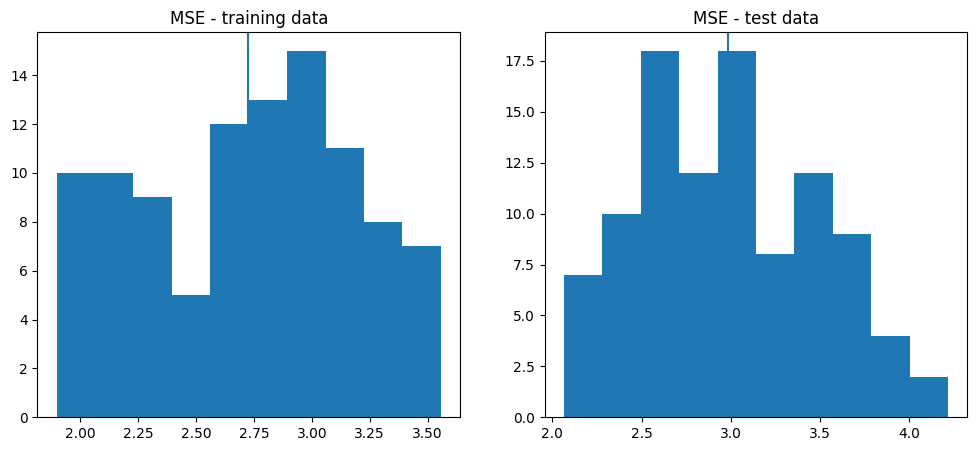

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt


advertising_df = pd.read_csv("../Daten/Advertising.csv", index_col= "Unnamed: 0")

draws = 100
mse_train_results, mse_test_results = [], []
for _ in range(draws):

    train_df = advertising_df.sample(frac = 0.50, replace=False)
    test_df = advertising_df.loc[[idx for idx in advertising_df.index if not(idx in train_df.index)], :]

    X_train, X_test = train_df.drop(["sales"], axis = 1), test_df.drop(["sales"], axis = 1)
    y_train, y_test = train_df.sales, test_df.sales

    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)

    mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)


fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_results)
axs[0].axvline(np.mean(mse_train_results))
axs[0].set_title("MSE - training data")

axs[1].hist(mse_test_results)
axs[1].axvline(np.mean(mse_test_results))
axs[1].set_title("MSE - test data")
plt.show()

## K-fold Kreuzvalidierung

Bei der K-fold Kreuzvalidierung wird der Datensatz in $k$ gleich große Teile aufgeteilt. Anschließend wird immer einer der Teile als Testdatensatz verwendet, während die restlichen Daten zum Trainieren des Modells verwendet werden. Dieser Vorgang wird $k$ Mal durch Iterieren über alle Teile (folds) durchgeführt. Die untere Grafik visualisiert diese Form der Datenaufteilung.

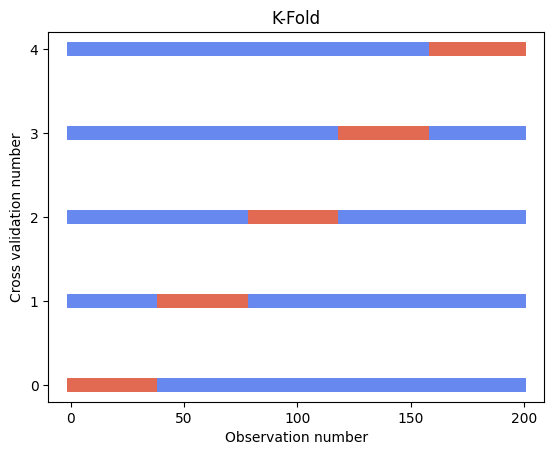

In [2]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

cmap_cv = plt.cm.coolwarm
n_splits = 5
cv = KFold(n_splits)


advertising_df = pd.read_csv("../Daten/Advertising.csv", index_col= "Unnamed: 0")
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=10,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )


ax.set_xticks(np.arange(0, 201, 50))
ax.set_yticks(np.arange(n_splits)+0.5)
ax.set_yticklabels([i for i in range(n_splits)])

ax.set_xlabel("Observation number")
ax.set_ylabel("Cross validation number")
ax.set_title("K-Fold")

plt.show()

Nach jeder Iteration haben wir einen Schätzer eines Testfehlers, beispielsweise für ein Regressionsproblem den $MSE_k = \frac{1}{n_k} \sum_{i \in k_{\text{fold}}} \left(y_i - \hat{y}_i\right)^2 $. Als finaler Schätzer des Testfehlers können wir den durchschnittlichen Testfehler über alle k-folds verwenden:

$$
CV_{(k)} = \frac{1}{k} \sum_k MSE_k
$$

In der nächsten Zelle wird die K-fold Kreuzvalidierung für der Advertising Datensatz mit $k=5$ durchgeführt. Da die Anzahl der Beobachtungen der Testdaten geringer ist, als bei der oberen Sampling-Methode schwanken die einzelnen Schätzungen $MSE_k$ der Testdaten stärker. Jedoch sehen wir, dass der eigentliche Schätzer $CV_{(k)}$ einen sehr ähnlichen Wert wie im oberen Beispiel annimmt. Zudem können mehr Daten zum Trainieren des Modells verwendet werden.

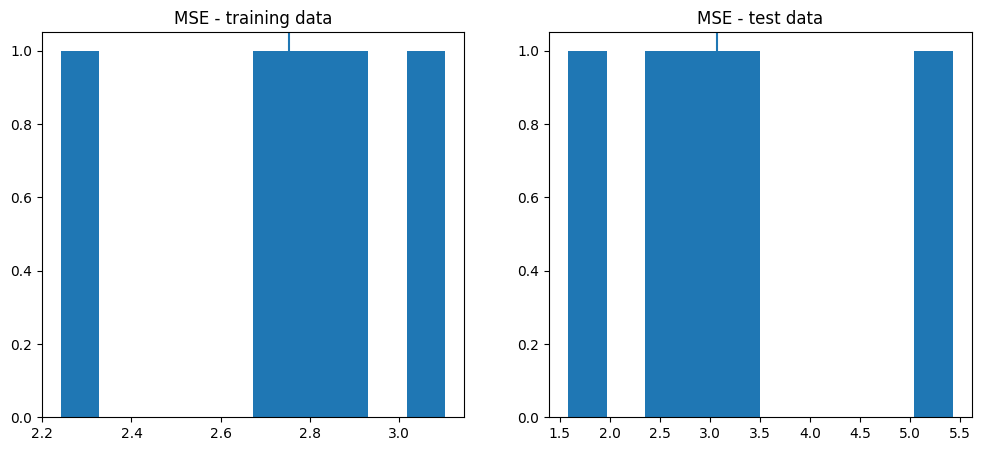

In [3]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


advertising_df = pd.read_csv("../Daten/Advertising.csv", index_col= "Unnamed: 0")
advertising_df.reset_index(drop = True, inplace = True)
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

n_splits = 5
cv = KFold(n_splits)

mse_train_results, mse_test_results = [], []
for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)
    
    mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_results)
axs[0].axvline(np.mean(mse_train_results))
axs[0].set_title("MSE - training data")

axs[1].hist(mse_test_results)
axs[1].axvline(np.mean(mse_test_results))
axs[1].set_title("MSE - test data")
plt.show()

Außderdem sollte man bei der Interpretion der Histogramme in der obigen Zelle vorsichtig sein. Es ist gerade der Vorteil der Kreuzvalidierung, dass wir die Evaluation des Modells nicht anhand der einzelnen Testfehler durchführen würden, sondern anhand deren Durchschnitt. Würden wir dieses Vorgehen mehrfach durchführen, wäre die Schwankung der geschätzten Werte für $CV_{(k)}$ deutlich geringer als bei der Methodes des einfachen Aufteilens der Daten. Um dies zu demonstrieren, verzichten wir für einen Moment auf die Reproduzierbarkeit des Wertes für $CV_{(k)}$ und führen die Kreuzvalidierung mit $k=5$ mehrfach durch indem wir die Teile der Daten doch zufällig aufteilen. Im Anschluss betrachten wir das Histogramm für alle Realisierungen von $CV_{(k)}$ über alle K-fold Durchläufe. Hierbei wird deutlich, dass die Beurteilung eines Modells anhand der K-Fold Validierung deutlich weniger mit unterschiedlichen (zufälligen) Aufteilungen von Trainings- und Testdaten variiert. Genau hierin besteht der Vorteil, da die Evaluation der Generalisierungsfähigkeit eines Modells stabiler mit Blick auf das Ziehen zufälliger Trainings- und Testdaten ist. 

Bei der hier vorgestellten Art der Kreuzvalidierung wird davon ausgegangen, dass die Beobachtungen der Daten keine Abhängigkeiten untereinander aufweisen. Diese Annahme ist verletzt, wenn Beobachtungen geographische, zeitliche oder andere Arten von Abhängigkeiten aufweisen. Beispielsweise kann es bei Zeitreihendaten problematisch sein, wenn durch die Art der fold-Bildung zukünftige Daten für die Prognose vergangenere Daten verwendet werden könnnen. Hierdurch können systematische Fehleinschätungen der Modellgüte entstehen, weshalb derartige Zusammenhänge bei Bedarf angepasst werden. Dies muss jedoch je nach Problemstellung spezifisch durchgeführt werden.

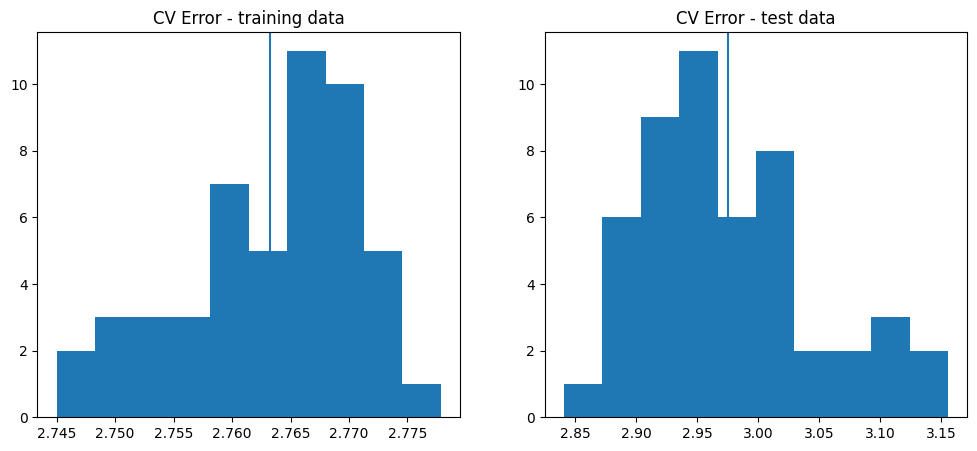

In [4]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


advertising_df = pd.read_csv("../Daten/Advertising.csv", index_col= "Unnamed: 0")
advertising_df.reset_index(drop = True, inplace = True)
X = advertising_df.drop(["sales"], axis = 1)
y = advertising_df.sales

n_splits = 5
n_fold_runs = 50

mse_train_cv, mse_test_cv = [], []
for fold_run in range(n_fold_runs):
    cv = KFold(n_splits, shuffle = True)
    mse_train_results, mse_test_results = [], []
    for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.loc[train_idx, :], X.loc[test_idx, :]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)
        y_train_hat, y_test_hat = linear_regression.predict(X_train), linear_regression.predict(X_test)
        
        mse_train, mse_test = mean_squared_error(y_train, y_train_hat), mean_squared_error(y_test, y_test_hat)
        mse_train_results.append(mse_train)
        mse_test_results.append(mse_test)
    mse_train_cv.append(np.mean(mse_train_results))
    mse_test_cv.append(np.mean(mse_test_results))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].hist(mse_train_cv)
axs[0].axvline(np.mean(mse_train_cv))
axs[0].set_title("CV Error - training data")

axs[1].hist(mse_test_cv)
axs[1].axvline(np.mean(mse_test_cv))
axs[1].set_title("CV Error - test data")
plt.show()